# Data Processing - Sidewalk Detection

In [111]:
import os
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random

In [77]:
# IMPORTANT
# RENAME FOLDER "Dataset_Complete" TO "Data"
# MOVE ALL TESTING DATA AND MERGE IT TO TRAINING DATA; "Test_set" to "Train_set", EACH FOLDER CORRESPONDINGLY

In [102]:
def process_image (image_path):
    image = cv2.imread(image_path)
    
    if image.shape == (1080, 1920, 3):
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    #cvt_color = cv2.COLOR_BGR2RGB
    
    #image = cv2.cvtColor(image, cvt_color)
    return image

def get_sidewalk_mask (raw_image_path: str, masks_path: list):
    
    """
    Processes images and returns both the raw image and its corresponding mask
    
    """
    if not os.path.isfile(raw_image_path):
        raise Exception("Image path points to non-existant or deleted file")
        return 
    image_raw = process_image(raw_image_path)
    
    image_mask_added = np.zeros(shape= image_raw.shape, dtype= np.uint8)
    masks_path = list(filter(os.path.isfile, masks_path))
    
    if len(masks_path) > 0:
        
        image_masks = list(map(process_image, masks_path))
        for image in image_masks:
            image_mask_added += image

    image_mask_added[image_mask_added > 255], image_mask_added[image_mask_added < 0] = 255, 0  
    
    assert image_mask_added.shape == image_raw.shape, f"Segmentation mask shape {image_mask_added.shape} ! raw image shape {image_raw.shape}"
    
    return image_raw, image_mask_added

def visualize_images (image_raw: np.ndarray, image_mask: np.ndarray, mask_alpha: float): 
    
    fig = plt.figure(figsize= (10, 10))
    
    # Raw image
    fig.add_subplot(2, 3, 1)
    plt.imshow(image_raw)
    plt.title('Raw image')
    
    # Segmentation mask
    fig.add_subplot(2, 3, 3)
    plt.imshow(image_mask)
    plt.title('Segmentation Mask')
    
    # Raw + mask
    fig.add_subplot(2, 3, 5)
    plt.imshow(cv2.addWeighted(image_raw, 1, image_mask, mask_alpha, 0))
    plt.title('Raw + mask')

def create_dataset (root_data_dir: str, image_raw: np.ndarray, image_mask: np.ndarray) -> None:
    """
    Creates the dataset directory and performs train/val/test split
    """
    

## Data Visualization

In [3]:
raw_dataset_path = 'Data/Train_set/Raw_data'
mask_right = 'Data/Train_set/Right_sidewalk'
mask_straight = 'Data/Train_set/Straight_sidewalk'
mask_left = 'Data/Train_set/Left_sidewalk'

In [159]:
i = 1
image_path_raw = f'{raw_dataset_path}/Raw_{i}.jpg'
image_path_r = f'{mask_right}/Label_{i}.jpg'
image_path_l = f'{mask_left}/Label_{i}.jpg'
image_path_s = f'{mask_straight}/Label_{i}.jpg'

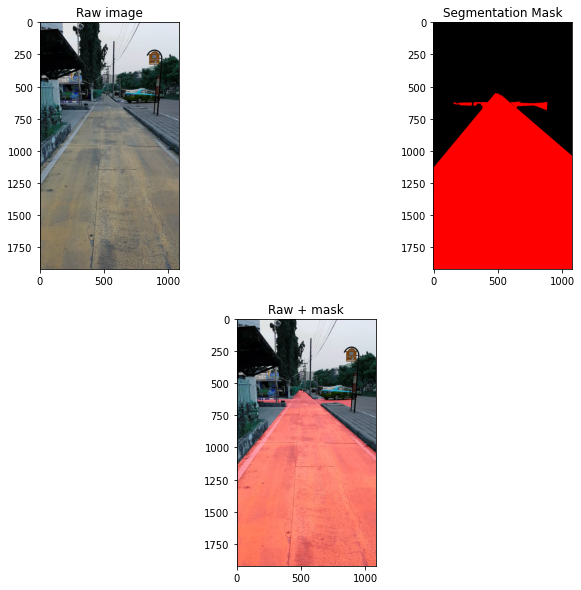

In [160]:
image_raw, image_mask = get_sidewalk_mask(image_path_raw, [image_path_r, image_path_l, image_path_s])
image_mask[:, :, 1] = 0
image_mask[:, :, 2] = 0
visualize_images(image_raw, image_mask, 0.5)

## Data Examination

In [57]:
# Datapoints

path = "Data/Train_set"
images_type = ["Raw_data", "Left_sidewalk", "Right_sidewalk", "Straight_sidewalk"]
images_paths = {}

for type_ in images_type:
    images_paths[type_] = [f"{path}/{type_}/{image}" for image in os.listdir(f"{path}/{type_}")]

print(f"There are {len(images_paths['Raw_data'])} images in the entire dataset")

There are 326 images in the entire dataset


In [69]:
def check_images_size (images_path):
    sizes = []
    log = {}
    for path in images_path:
        image = cv2.imread(path)
        sizes.append(image.shape)
    
    sizes_bool = list(map(lambda x: x==sizes[0], sizes))
    if not all(sizes_bool):
        for i in range(len(sizes)):
            if not sizes_bool[i]:
                log_error = f"Different image size at: {images_path[i]}, size: {sizes[i]} with other majority sizes: {sizes[0]}"
                log[images_path[i]] = sizes[i]
                print(log_error)
    else:
        print("All images are the same size")
    return log

In [70]:
# Load sample images to get the shape
sample_raw_image = cv2.imread(images_paths["Raw_data"][0])
sample_mask_l = cv2.imread(images_paths["Left_sidewalk"][0])
sample_mask_r = cv2.imread(images_paths["Right_sidewalk"][0])
sample_mask_s = cv2.imread(images_paths["Straight_sidewalk"][0])

print(f"Sample raw image shape: {sample_raw_image.shape}")
print(f"Sample right mask image shape: {sample_mask_r.shape}")
print(f"Sample left mask image shape: {sample_mask_l.shape}")
print(f"Sample straight mask image shape: {sample_mask_s.shape}")

Sample raw image shape: (1080, 1920, 3)
Sample right mask image shape: (1080, 1920, 3)
Sample left mask image shape: (1080, 1920, 3)
Sample straight mask image shape: (1080, 1920, 3)


In [71]:
# Check if all images are the same size
log_raw = check_images_size(images_paths["Raw_data"])

Different image size at: Data/Train_set/Raw_data/Raw_312.jpg, size: (1920, 1080, 3) with other majority sizes: (1080, 1920, 3)


In [72]:
log_mask_r = check_images_size(images_paths["Right_sidewalk"])

All images are the same size


In [73]:
log_mask_l = check_images_size(images_paths["Left_sidewalk"])

All images are the same size


In [74]:
log_mask_s = check_images_size(images_paths["Straight_sidewalk"])

All images are the same size


In [75]:
# We only have 326 images in our dataset
# As a starting point, using transfer learning for feature extraction, we can start training our model on this data
# and then move on to bigger data as we increase compute capability

## Restructuring the Data

In [136]:
# First we process the data to have one label image (segmentation mask) per raw image 
root_dir = os.getcwd()

def check_dir (root_dir):
    
    """
    Creates new data folder structure: 
    
    |-- root_dir:
    |   |-- train:
    |   |   |-- image:
    |   |   |   |-- Raw_0.jpg
    |   |   |   |-- Raw_1.jpg
    |   |   |-- label:
    |   |   |   |-- Label_0.jpg
    |   |   |   |-- Label_1.jpg
    
    """
    
    if not os.path.isdir(f"{root_dir}/Data/train"):
        os.mkdir(f"{root_dir}/Data/train")
        os.mkdir(f"{root_dir}/Data/train/image")
        os.mkdir(f"{root_dir}/Data/train/label")
        
    if not os.path.isdir(f"{root_dir}/Data/train"):
        os.mkdir(f"{root_dir}/Data/train")
        
    if not os.path.isdir(f"{root_dir}/Data/train/image"):
        os.mkdir(f"{root_dir}/Data/train/image")
    
    if not os.path.isdir(f"{root_dir}/Data/train/label"):
        os.mkdir(f"{root_dir}/Data/train/label")
        
    if not os.path.isdir(f"{root_dir}/Data/val"):
        os.mkdir(f"{root_dir}/Data/val")
        
    if not os.path.isdir(f"{root_dir}/Data/val/image"):
        os.mkdir(f"{root_dir}/Data/val/image")
    
    if not os.path.isdir(f"{root_dir}/Data/val/label"):
        os.mkdir(f"{root_dir}/Data/val/label")
    
    if not os.path.isdir(f"{root_dir}/Data/test"):
        os.mkdir(f"{root_dir}/Data/test")
    
    if not os.path.isdir(f"{root_dir}/Data/test/image"):
        os.mkdir(f"{root_dir}/Data/test/image")

In [137]:
check_dir(root_dir)

In [138]:
# Copy data to train dir
for i in range(len(images_paths["Raw_data"])):
    image_path_raw = f'{raw_dataset_path}/Raw_{i}.jpg'
    image_path_r = f'{mask_right}/Label_{i}.jpg'
    image_path_l = f'{mask_left}/Label_{i}.jpg'
    image_path_s = f'{mask_straight}/Label_{i}.jpg'
    
    image, mask = get_sidewalk_mask (image_path_raw, [image_path_r, image_path_l, image_path_s])
    cv2.imwrite(f"{root_dir}/Data/train/image/Raw_{i}.jpg", image)
    cv2.imwrite(f"{root_dir}/Data/train/label/Label_{i}.jpg", mask)

## Train/Val/Test Split

In [139]:
# Check number of training images and labels

train_images = os.listdir("Data/train/image")
train_labels = os.listdir("Data/train/label")

print(f"There are {len(train_images)} training images and {len(train_labels)} training labels")

There are 326 training images and 326 training labels


In [140]:
# Since for each image we have a corresponding label we can move on to splitting the data
# A good train/val/test split would be 276/45/5
# We randomly move 45 images and the corresponding labels to the val folder and 5 to the test folder

index = [x.split('.')[0].split('_')[1] for x in train_images]
val = 45
test = 5

In [141]:
for i in range(val):
    shutil.move(f"Data/train/image/Raw_{index[i]}.jpg", f"Data/val/image/Raw_{index[i]}.jpg")
    shutil.move(f"Data/train/label/Label_{index[i]}.jpg", f"Data/val/label/Label_{index[i]}.jpg")
    index.pop(i)
    random.shuffle(index)

In [142]:
for i in range(test):
    shutil.move(f"Data/train/image/Raw_{index[i]}.jpg", f"Data/test/image/Raw_{index[i]}.jpg")
    os.remove(f"Data/train/label/Label_{index[i]}.jpg")
    index.pop(i)
    random.shuffle(index)

In [148]:
print(f"Number of training images: {len(os.listdir('Data/train/image'))}")
print(f"Number of training labels: {len(os.listdir('Data/train/label'))}")
print(f"Number of validation images: {len(os.listdir('Data/val/image'))}")
print(f"Number of validation labels: {len(os.listdir('Data/val/label'))}")
print(f"Number of testing images: {len(os.listdir('Data/test/image'))}")

Number of training images: 276
Number of training labels: 276
Number of validation images: 45
Number of validation labels: 45
Number of testing images: 5
